In [1]:
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from xgboost import plot_tree
import torch
import sys
sys.path.insert(1, '../../models/Multi-Body')
from multidataset import MultiDataset
from multimodel import Net as Model

/raid/projects/akhot2/conda/envs/akhot2/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
#TopoDNN or Multi-Body
dataset = 'Multi-Body'
options = '_tau_x_1'
if dataset == 'TopoDNN':
    # Load inputs
    df_test = pd.read_pickle("../../datasets/topoprocessed/test.pkl")
    x_test = df_test.loc[:, df_test.columns != 'is_signal_new']
    y_test = df_test["is_signal_new"]
    del df_test
    
    labels = x_test.columns
    
if dataset == 'TopoDNN_combo':
    # Load inputs
    df_test = pd.read_pickle("../../datasets/topoprocessed/test.pkl")
    x_test_1 = df_test.loc[df_test['pt_16'] == 0, df_test.columns != 'is_signal_new']
    y_test_1 = df_test.loc[df_test['pt_16'] == 0, df_test.columns == 'is_signal_new']
    
    x_test_2 = df_test.loc[df_test['pt_16'] != 0, df_test.columns != 'is_signal_new']
    y_test_2 = df_test.loc[df_test['pt_16'] != 0, df_test.columns == 'is_signal_new']
    
    x_test = df_test.loc[:, df_test.columns != 'is_signal_new']
    y_test = df_test["is_signal_new"]
    
    del df_test
    dataset='TopoDNN'
    #Load model
    from keras.models import load_model
    topodnnmodel = load_model("../../models/TopoDNN/topodnnmodels/topodnnmodel/")
    
    labels = x_test.columns
    
if dataset == 'TopoDNN_30':
    # Load inputs
    df_test = pd.read_pickle("../../datasets/topoprocessed/test.pkl")
    x_test = df_test.loc[:, df_test.columns != 'is_signal_new']
    y_test = df_test["is_signal_new"]
    del df_test
    
    x_test = x_test.iloc[:, :30]
    labels = x_test.columns
if dataset == 'Multi-Body':
    
    #Parameters to change
    use_jet_pt = True
    use_jet_mass = True
    tau_x_1 = True
    N = 8
    
    #Training and validation paths
    test_path = '../../datasets/n-subjettiness_data/test_all.npy'

    #Loading testing datasets
    test_set = MultiDataset(test_path, N, use_jet_pt, use_jet_mass, tau_x_1)
    
    x_test,y_test = test_set[:]    
    y_test = y_test[:,1]
    labels = []
    if not tau_x_1:
        for i in range(N-1):
            if i != N-2:
                labels.append('tau_'+str(i+1)+'_'+str(0.5))
                labels.append('tau_'+str(i+1)+'_'+str(1))
                labels.append('tau_'+str(i+1)+'_'+str(2))
            else:
                labels.append('tau_'+str(i+1)+'_'+str(1))
                labels.append('tau_'+str(i+1)+'_'+str(2))
        if use_jet_pt:
            labels.append('jet_pt')
        if use_jet_mass:
            labels.append('jet_mass')
    else:
        for i in range(N-1):
            labels.append('tau_'+str(i+1)+'_'+str(1))
        if use_jet_pt:
            labels.append('jet_pt')
        if use_jet_mass:
            labels.append('jet_mass')
if dataset == 'Multi-Body_combo':
    
    #Parameters to change
    use_jet_pt = True
    use_jet_mass = True
    tau_x_1 = True
    N = 8
    model_type = 'best'
    extra_name = ''
    #Training and validation paths
    test_path = '../../datasets/n-subjettiness_data/test_all.npy'
    #model path
    model_path = '../../models/Multi-Body/models/MultiBody' + str(N) + '-Subjettiness_mass' +str(use_jet_mass)+'_pt'+str(use_jet_pt)+'_'+ model_type + extra_name

    #Loading testing datasets
    test_set = MultiDataset(test_path, N, use_jet_pt, use_jet_mass, tau_x_1)
    #loading model
    multimodel = Model(N, use_jet_pt, use_jet_mass, tau_x_1).double()
    multimodel.load_state_dict(torch.load(model_path))
    multimodel.eval()
    x_test,y_test = test_set[:]    
    y_test = y_test[:,1]
    mass = 120/1000
    x_test_1 = np.delete(x_test, np.where(x_test[:,21]>mass), axis=0)
    y_test_1 = np.delete(y_test, np.where(x_test[:,21]>mass), axis=0)
    x_test_2 = x_test[np.where(x_test[:,21]>mass)]
    y_test_2 = y_test[np.where(x_test[:,21]>mass)]
    
    labels = []
    if not tau_x_1:
        for i in range(N-1):
            if i != N-2:
                labels.append('tau_'+str(i+1)+'_'+str(0.5))
                labels.append('tau_'+str(i+1)+'_'+str(1))
                labels.append('tau_'+str(i+1)+'_'+str(2))
            else:
                labels.append('tau_'+str(i+1)+'_'+str(1))
                labels.append('tau_'+str(i+1)+'_'+str(2))
        if use_jet_pt:
            labels.append('jet_pt')
        if use_jet_mass:
            labels.append('jet_mass')
    else:
        for i in range(N-1):
            labels.append('tau_'+str(i+1)+'_'+str(1))
        if use_jet_pt:
            labels.append('jet_pt')
        if use_jet_mass:
            labels.append('jet_mass')
    dataset='Multi-Body'

# load the model from disk
model = pickle.load(open('../../models/BDT/models/bdt_model_'+dataset+options+'.sav', 'rb'))

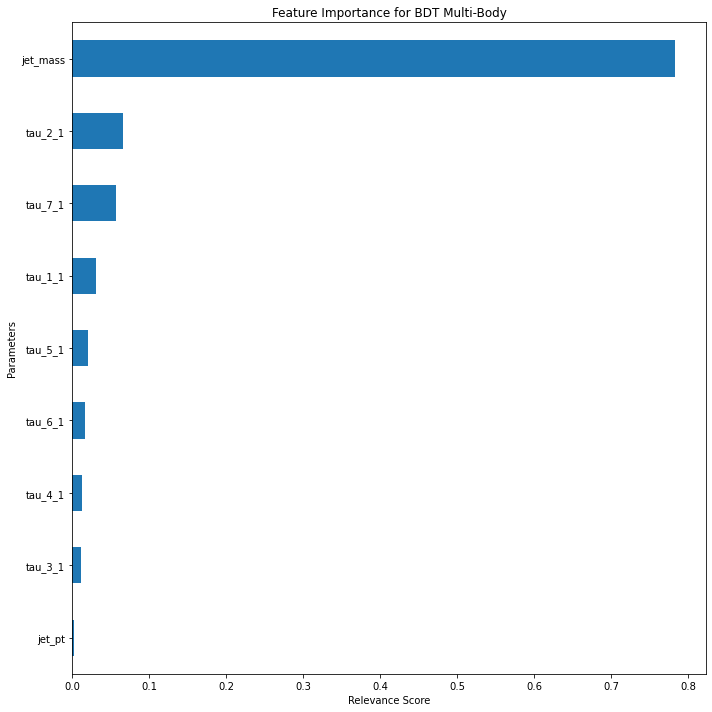

In [3]:
#Takes top max_display relevance scores
max_display = 20
forest_importances = pd.Series(model.feature_importances_, index=labels).sort_values().tail(max_display)

fig, ax = plt.subplots(figsize = (10, 10))
forest_importances.plot.barh(ax=ax)
ax.set_title("Feature Importance for BDT " + dataset)
ax.set_ylabel("Parameters")
ax.set_xlabel("Relevance Score")
fig.tight_layout()
#Savings feature importance bar graph
#plt.savefig("figures/BDT_featureimportance_"+dataset+options+".png", dpi = 150, bbox_inches='tight')
plt.show()

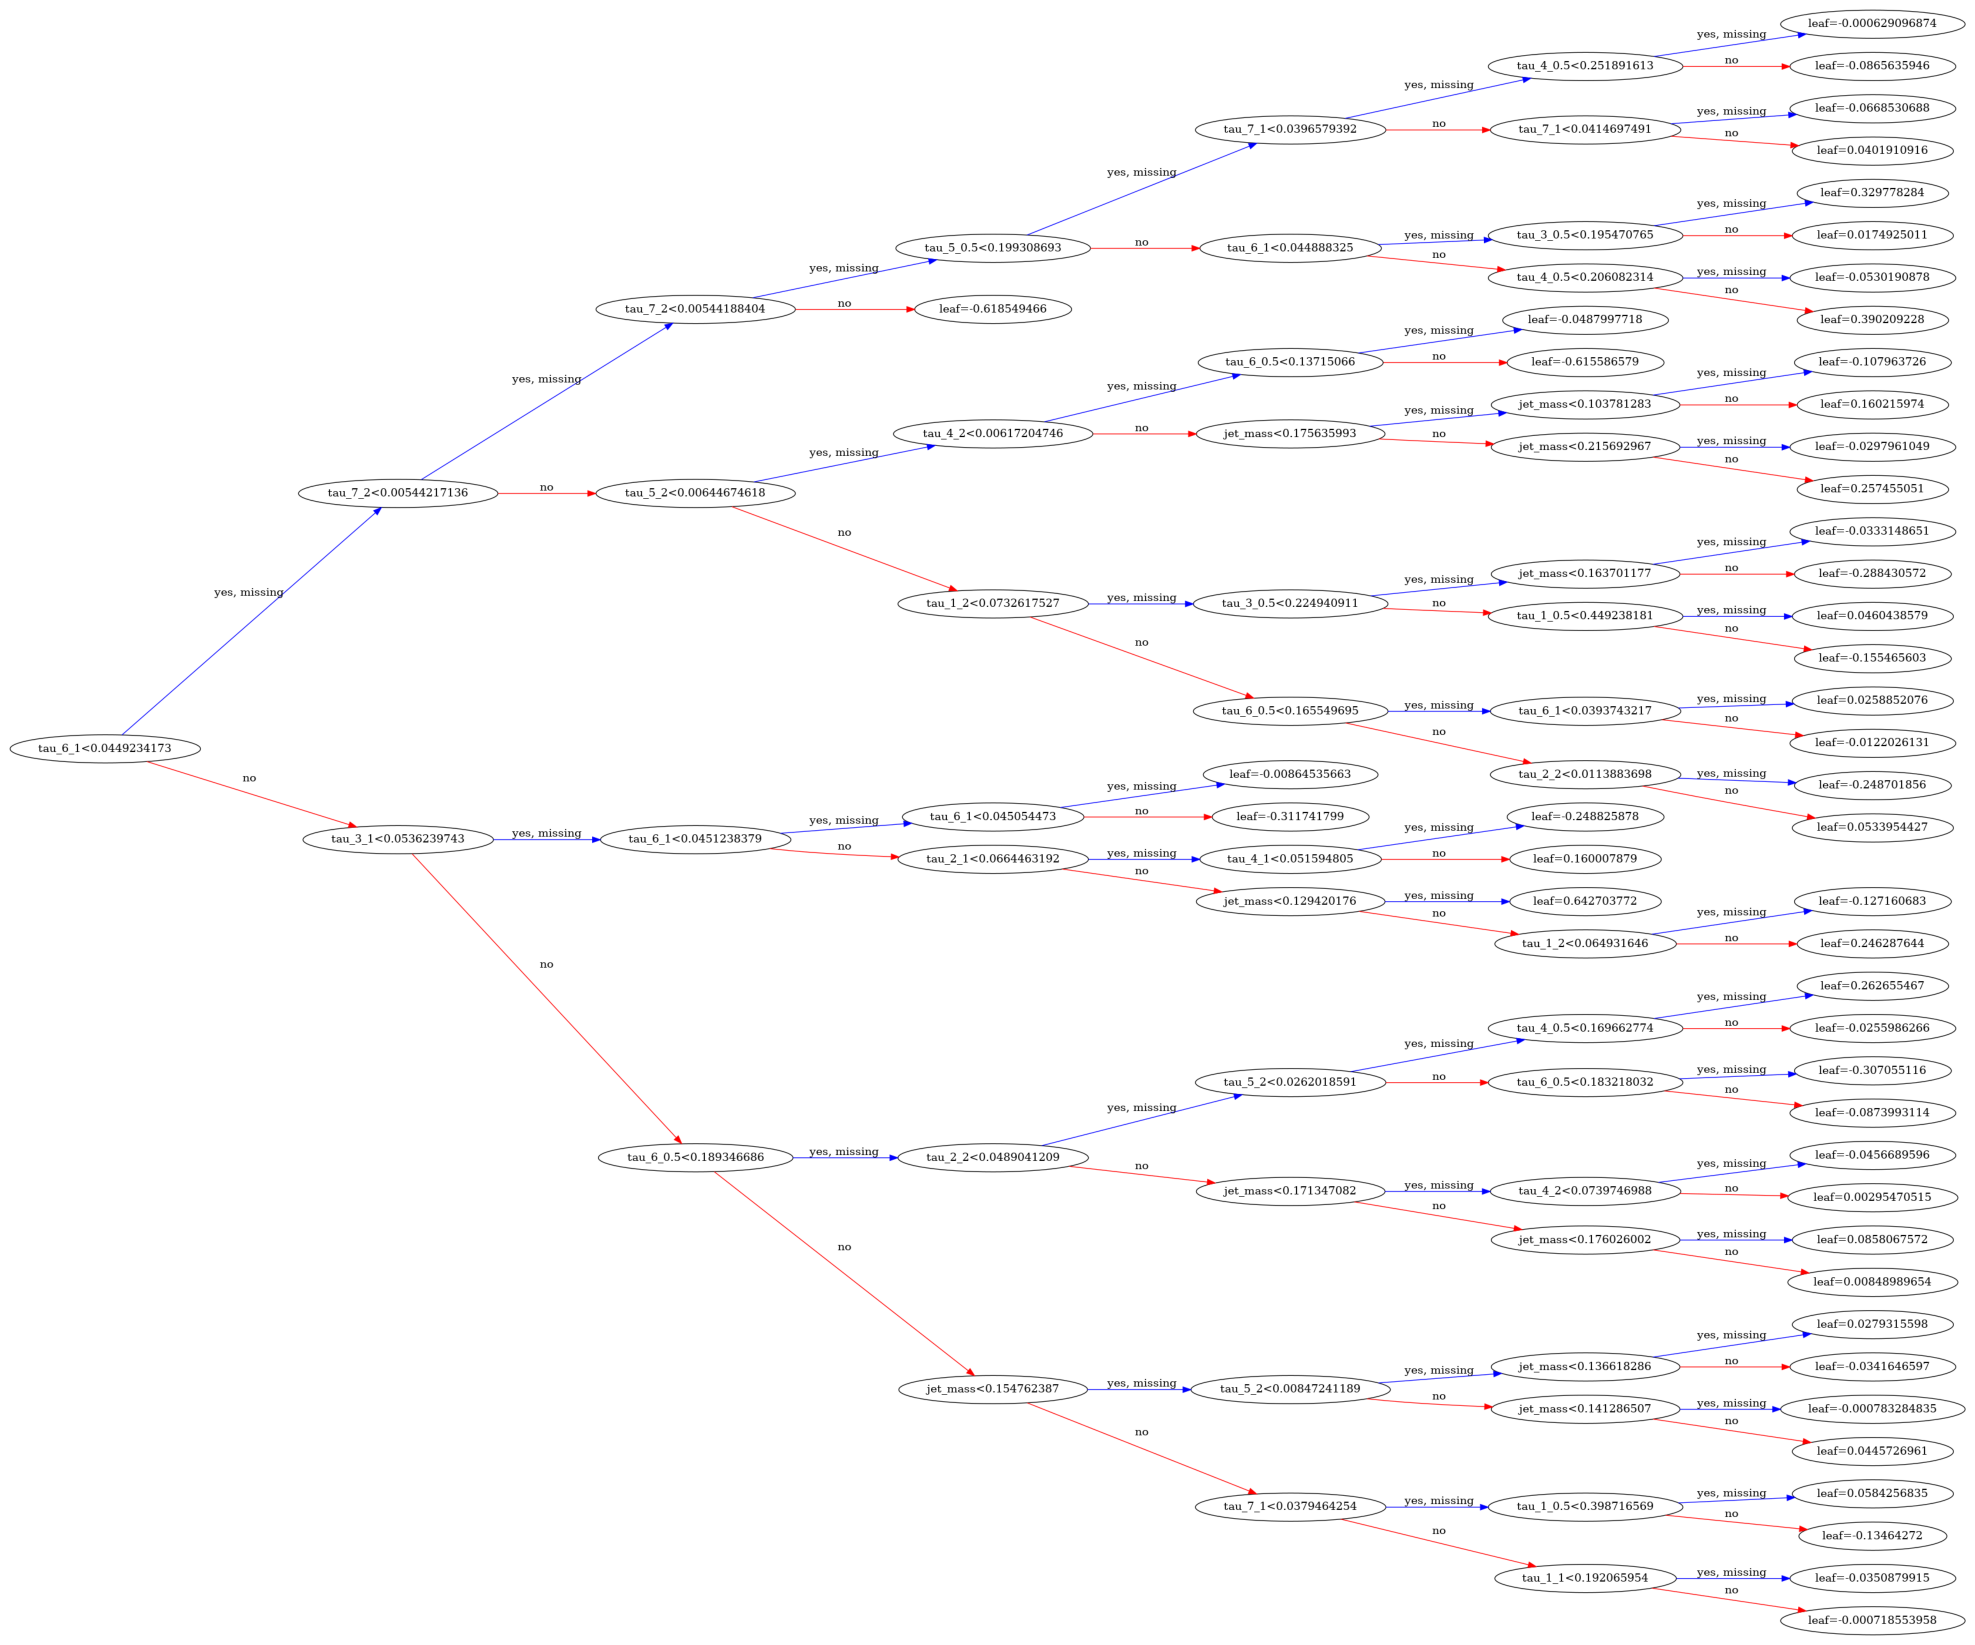

In [4]:
fig, ax = plt.subplots(figsize=(50, 30))
plot_tree(model, num_trees=99, ax=ax, rankdir = 'LR')
plt.show()

In [94]:
#Accuracy of BDT and TopoDNN combo
# make predictions for test data
y_pred = model.predict(x_test_1)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test_1, predictions)
print("Test Accuracy of BDT Augmented on pt_20~0: %.2f%%" % (accuracy * 100.0))

Test Accuracy of BDT Augmented on pt_20~0: 99.99%


/raid/projects/akhot2/conda/envs/akhot2/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [95]:
score = topodnnmodel.evaluate(x_test_2, y_test_2, batch_size=96)
print("Test Accuracy of TopoDNN Augmented on pt_20>0: "+str(score[1]))

4127/4127 [==============================] - 5s 1ms/step - loss: 0.2113 - accuracy: 0.9139
Test Accuracy of TopoDNN Augmented on pt_20>0: 0.9138973355293274


In [96]:
total_acc = (len(x_test_1)*accuracy + len(x_test_2)*score[1])/(len(x_test_1)+len(x_test_2))
print("Total accuracy: " + str(total_acc))

Total accuracy: 0.9155668291005463


In [84]:
len(x_test_2)/len(x_test_1)

0.49131420218381555

In [43]:
#Accuracy of BDT and TopoDNN by themselves
score = topodnnmodel.evaluate(x_test, y_test, batch_size=96)
print("Test Accuracy of TopoDNN: "+str(score[1]))
y_pred = model.predict(x_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Test Accuracy of BDT: %.2f%%" % (accuracy * 100.0))

NameError: name 'topodnnmodel' is not defined

In [57]:
#Accuracy of BDT and Multi-Body combo
# make predictions for test data
y_pred = model.predict(x_test_1)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test_1, predictions)
print("Test Accuracy of BDT Augmented on jet mass: %.2f%%" % (accuracy * 100.0))

Test Accuracy of BDT Augmented on jet mass: 98.85%


In [58]:
with torch.no_grad():
    multiaccuracy = accuracy_score(multimodel(torch.from_numpy(x_test)).round()[:,1], y_test)
print('Test Accuracy of Multi-Body augmented on jet mass: '+ str(multiaccuracy))

Test Accuracy of Multi-Body augmented on jet mass: 0.9281466625321343


In [59]:
total_acc = (len(x_test_1)*accuracy + len(x_test_2)*multiaccuracy)/(len(x_test_1)+len(x_test_2))
print("Total accuracy: " + str(total_acc))

Total accuracy: 0.9509126616970295


In [4]:
y_pred = model.predict(x_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)

In [5]:
print(accuracy)

0.9196166888397636
